In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import string
import random
import cvxpy

# 1. Simulating and Visualizing a Custom Probability Distribution

This process involves generating random samples that follow a custom cumulative distribution function (CDF) \( F(x) \) using the **Inverse Transform Sampling** method. The steps are as follows:

1. **Understanding the Given CDF $F(x)$:**

   The CDF $F(x)$ is defined piecewise as:
   $$
   F(x) =
   \begin{cases}
   0 & x < 0 \\
   \frac{x^2}{3} & 0 \le x < 1 \\
   \frac{1}{3} & 1 \le x < 2 \\
   \frac{x + 2}{6} & 2 \le x < 4 \\
   1 & x \ge 4
   \end{cases}
   $$
   This represents a hybrid distribution: quadratic growth, flat region, then linear growth.

2. **Sampling from the Uniform Distribution:**

   Generate $N = 1000$ samples from a uniform distribution $U(0, 1)$. These are stored in an array named `array_samples_uniform`.

3. **Inverse Transform Sampling:**

   To simulate samples that follow $F(x)$, we apply its inverse $F^{-1}(u)$ to each uniform sample $u \in [0, 1]$. This transformation yields samples that follow the custom distribution. The inverse function is defined piecewise by solving $F(x) = u$ for each interval.

4. **Transformed Samples:**

   The result of applying $F^{-1}$ to all uniform samples gives `array_samples_custom`, which follows the target distribution.

5. **Visualization:**

   - **Empirical CDF:** Plot the empirical cumulative distribution function from the transformed samples using a step plot.
   - **Theoretical CDF:** Plot the given theoretical CDF $F(x)$ on a separate figure for comparison.
   - **Animation:** We use `matplotlib.animation.FuncAnimation` to animate the empirical CDF as the number of samples $N$ increases from 10 to 1000. At each frame, a subset of samples is used to show how the empirical CDF converges to the theoretical one.

In [2]:
np.random.seed(100)  # Set random seed for reproducibility
array_samples_uniform = np.random.rand(1000)  # Generate 1000 samples from a uniform distribution over [0, 1)

In [3]:
def inverse_cdf(u):
    u = np.asarray(u)
    x = np.zeros_like(u, dtype=float)  # Initialize output array with same shape as u

    # For u in [0, 1/3), use inverse of F(x)=x²/3 -> x = sqrt(3u) maps to x in [0, 1)
    condition_1 = (u >= 0) & (u < 1/3)
    x[condition_1] = np.sqrt(3 * u[condition_1])

    # For u approximately equal to 1/3, set x = 1
    condition_2 = np.isclose(u, 1/3)
    x[condition_2] = 1.0

    # For u in (1/3, 2/3), set x = 2
    condition_3 = (u > 1/3) & (u < 2/3)
    x[condition_3] = 2.0

    # For u in [2/3, 1), solve 6u - 2 = x to invert F(x) = (x + 2)/6, x in [2, 4)
    condition_4 = (u >= 2/3) & (u < 1.0)
    x[condition_4] = 6 * u[condition_4] - 2

    # For u approximately equal to 1, return x = 4\
    condition_5 = np.isclose(u, 1.0)
    x[condition_5] = 4.0

    # Return scalar if input was scalar, else return array
    if u.ndim == 0:
        return x.item()
    return x

In [5]:
inverse_cdf_vectorized = np.vectorize(inverse_cdf)  # Vectorize the inverse_cdf function to apply it element-wise on arrays

# Transform each uniform sample to follow the custom distribution using inverse transform sampling
array_samples_custom = inverse_cdf_vectorized(array_samples_uniform)

In [4]:
def theoretical_cdf(x):
    result = np.zeros_like(x, dtype=float)  # Initialize result array with same shape as x

    # Define intervals based on piecewise CDF definition
    mask_neg = x < 0                  # For x < 0 -> F(x) = 0
    mask_0_to_1 = (x >= 0) & (x < 1)  # For x in [0, 1) -> F(x) = x² / 3
    mask_1_to_2 = (x >= 1) & (x < 2)  # For x in [1, 2) -> F(x) = 1/3 (flat segment)
    mask_2_to_4 = (x >= 2) & (x < 4)  # For x in [2, 4) -> F(x) = (x + 2) / 6
    mask_4_plus = x >= 4             # For x ≥ 4 -> F(x) = 1

    # Apply piecewise definitions
    result[mask_neg] = 0
    result[mask_0_to_1] = (x[mask_0_to_1]**2) / 3
    result[mask_1_to_2] = 1/3
    result[mask_2_to_4] = (x[mask_2_to_4] + 2) / 6
    result[mask_4_plus] = 1

    return result

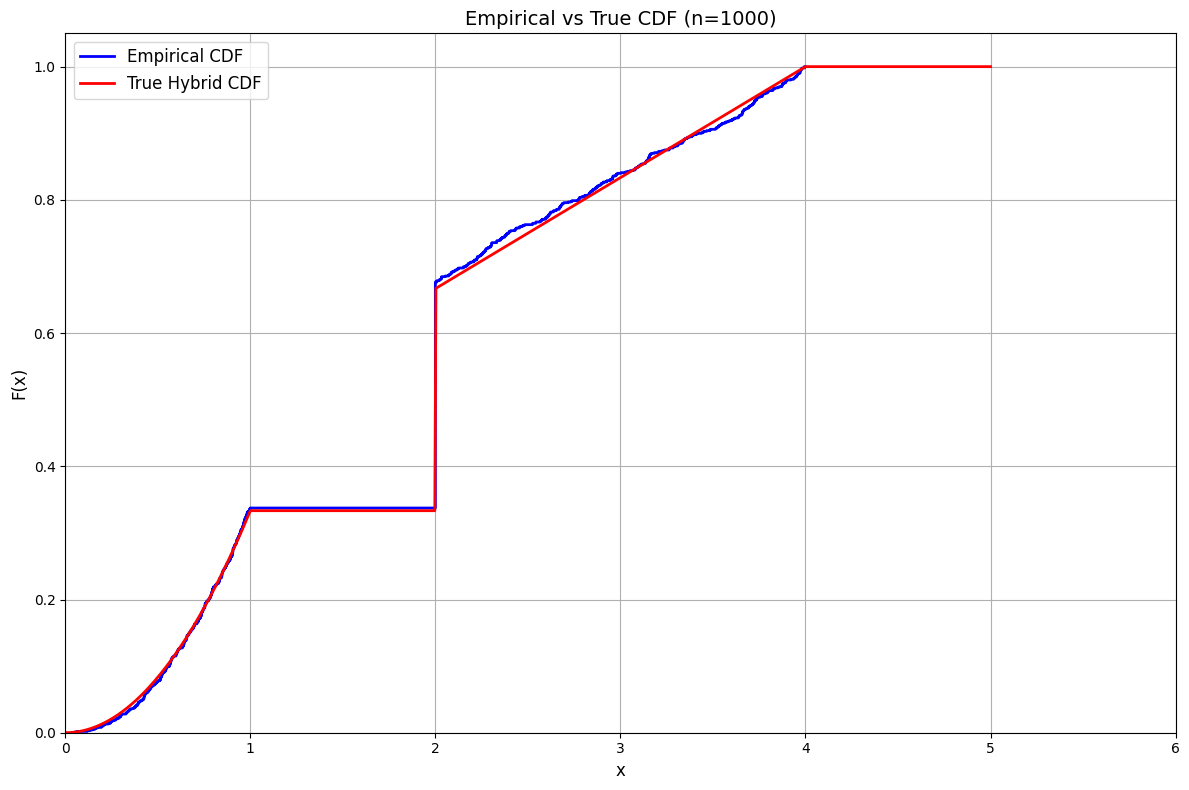

In [6]:
x_grid = np.linspace(-1, 5, 1000)
cdf_values = theoretical_cdf(x_grid)

# Plot the empirical CDF for array_samples_custom
plt.figure(figsize=(12, 8))
plt.step(np.sort(array_samples_custom), np.linspace(0, 1, len(array_samples_custom)), where='post', 
         label='Empirical CDF', color='blue', linewidth=2)
plt.plot(x_grid, cdf_values, 'r-', label='True Hybrid CDF', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('F(x)', fontsize=12)
plt.title('Empirical vs True CDF (n=1000)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xlim(0, 6)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

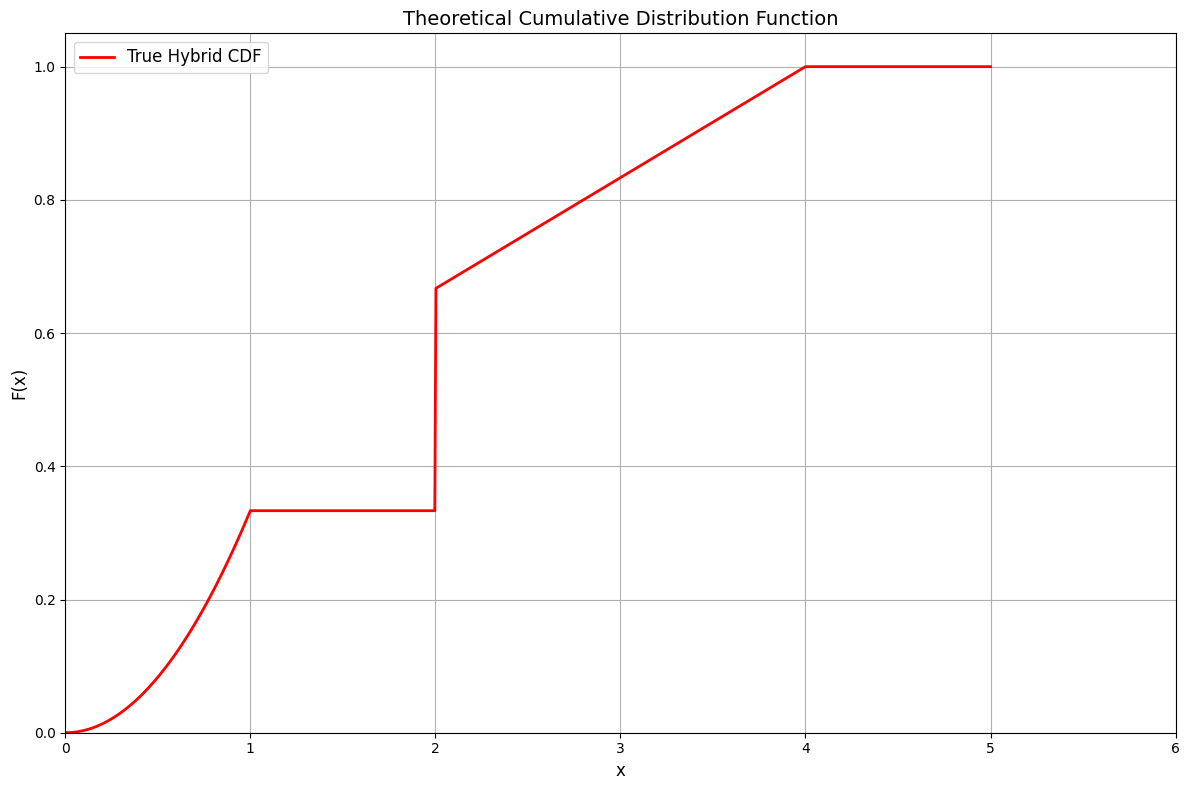

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(x_grid, cdf_values, 'r-', linewidth=2, label='True Hybrid CDF')
plt.xlabel('x', fontsize=12)
plt.ylabel('F(x)', fontsize=12)
plt.title('Theoretical Cumulative Distribution Function', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.xlim(0, 6)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

def update(frame):
    ax.clear()
    N = int(10 * (1.3**frame))  # Scale N exponentially from 10 to about 1000
    if N > 1000:
        N = 1000
    
    # Randomly sample N points from array_samples_custom
    indices = np.random.choice(len(array_samples_custom), size=N, replace=False)
    samples = np.sort(array_samples_custom[indices])
    
    # Plot the empirical CDF for the current subset
    ax.step(samples, np.linspace(0, 1, len(samples)), where='post', 
            label='Empirical CDF', color='blue', linewidth=2)
    
    # Plot the theoretical CDF
    ax.plot(x_grid, cdf_values, 'r-', label='True Hybrid CDF', linewidth=2)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('F(x)', fontsize=12)
    ax.set_title(f'Empirical vs True CDF (n={N})', fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=12)
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 1.05)
    
    return ax,

# Create animation with more frames and slower speed
ani = FuncAnimation(fig, update, frames=range(40), interval=250, blit=False)
ani.save('Plots/cdf_animation.gif', writer='pillow', fps=4, dpi=120)
plt.close()

# 2. Wordle: A Game in Probability

In [9]:
# Read the CSV file containing the word list with no header
words_df = pd.read_csv('wordlist.csv', header=None, names=['word'])

# Clean each word: remove leading/trailing spaces and convert to lowercase
words_df['word'] = words_df['word'].str.strip().str.lower()

# Convert the cleaned words into a regular Python list
word_list = words_df['word'].tolist()

In [10]:
word_count = len(words_df)
print(f"Total number of words loaded: {word_count}")

Total number of words loaded: 3103


In [11]:
# Initialize a nested dictionary to count occurrences of each letter (a-z) at each of the 5 positions (0 to 4)
letter_counts = {pos: {letter: 0 for letter in string.ascii_lowercase} for pos in range(5)}

# Iterate over each word in the DataFrame
for _, row in words_df.iterrows():
    word = row['word']
    # Count each letter's occurrence at its position (index 0 to 4)
    for i, letter in enumerate(word):
        if letter in string.ascii_lowercase:
            letter_counts[i][letter] += 1

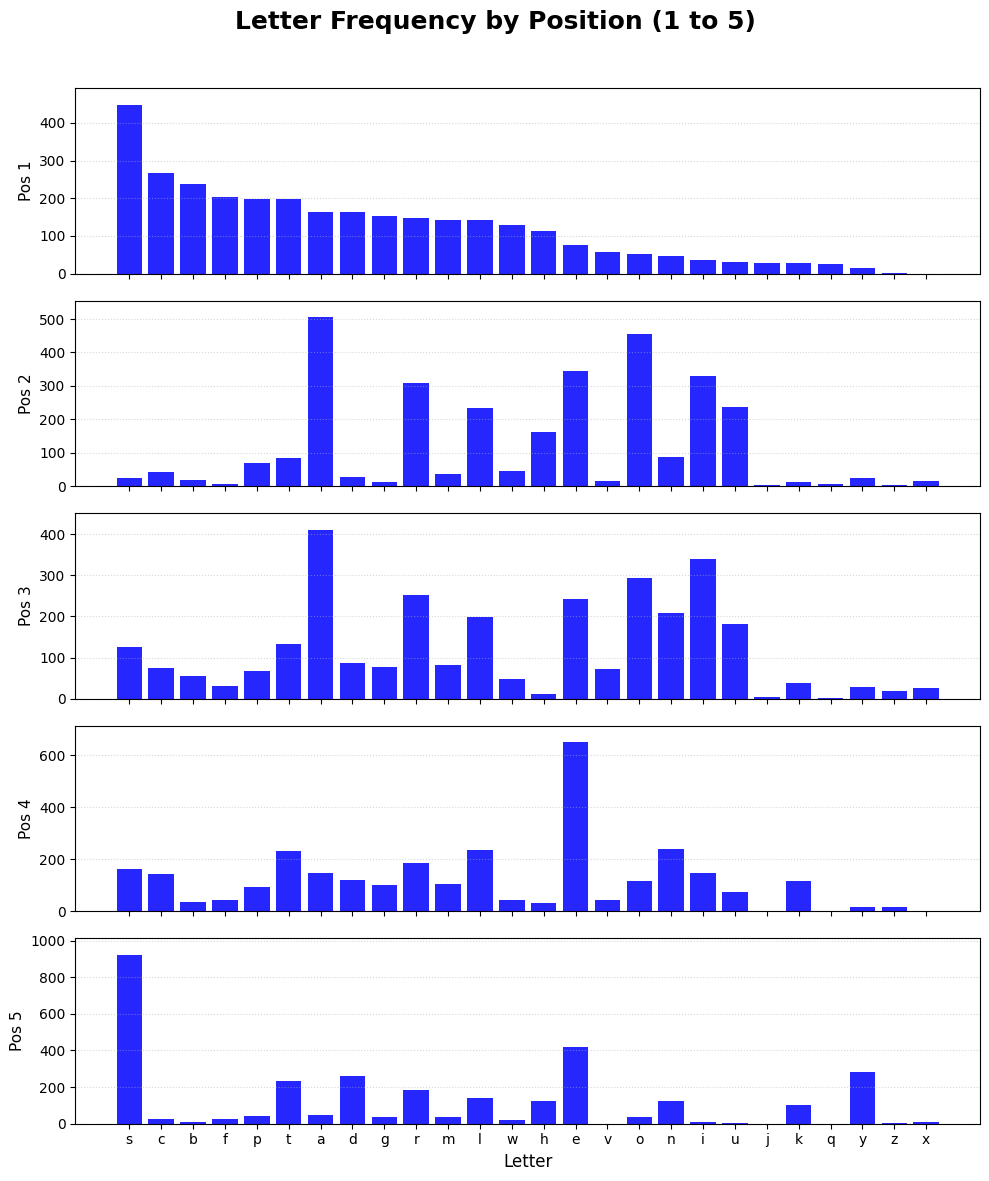

In [12]:
# Create a vertical stack of 5 subplots (one for each letter position in a 5-letter word)
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Letter Frequency by Position (1 to 5)', fontsize=18, fontweight='bold')

# Loop over each position and corresponding axis
for pos, ax in enumerate(axes):
    # Get letter frequency dictionary for the current position and sort it by count (descending)
    letter_freq = letter_counts[pos]
    sorted_items = sorted(letter_freq.items(), key=lambda x: x[1], reverse=True)
    letters, counts = zip(*sorted_items)

    # Plot a bar chart of letter frequencies
    ax.bar(letters, counts, color='blue', alpha=0.85)
    ax.set_ylabel(f'Pos {pos+1}', fontsize=11)
    ax.grid(True, axis='y', linestyle=':', alpha=0.5)
    ax.set_ylim(0, max(counts) * 1.1)  # Slight padding on y-axis for visual clarity

# Label the x-axis and adjust layout to prevent overlap with the title
axes[-1].set_xlabel('Letter', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Explanation of the `wordle_feedback` Function

The `wordle_feedback` function simulates the feedback mechanism in the game Wordle, comparing a guess against a solution to calculate how many letters are correctly placed (green), how many are correct but misplaced (yellow), and how many are incorrect (gray).

#### Process:

1. **Input Handling:**
   - Both the solution and the guess are converted to lowercase for case-insensitive comparison.

2. **Initialization:**
   - Three variables (`green`, `yellow`, `gray`) are initialized to 0 to store the counts of exact matches (green), partial matches (yellow), and incorrect letters (gray).
   - Two lists (`solution_remaining` and `guess_remaining`) are created as mutable copies of the solution and guess to track which letters have already been matched.

3. **First Pass (Exact Matches - Green):**
   - For each position (from 0 to 4), the function checks if the letter in the guess matches the letter in the solution at the same position.
   - If a match is found, the `green` counter is incremented, and both the solution and guess at that position are marked as processed (`_` and `*`, respectively).

4. **Second Pass (Partial Matches - Yellow):**
   - The function then checks for partial matches, i.e., letters that appear in the solution but are in the wrong position.
   - For each remaining letter in the guess (not already marked), it checks if it exists in the remaining solution letters.
   - If a match is found, the `yellow` counter is incremented, and the matched solution letter is marked as processed.

5. **Gray Count:**
   - The `gray` count is calculated by subtracting the number of green and yellow matches from 5 (the total number of letters), since the remaining letters must be incorrect.

#### Output:
The function returns a tuple `(green, yellow, gray)` representing the number of correct positions, correct letters in wrong positions, and incorrect letters, respectively.

In [13]:
def wordle_feedback(solution, guess):
    # Convert both solution and guess to lowercase for case-insensitive comparison
    solution = solution.lower()
    guess = guess.lower()
    
    # Initialize counters for green, yellow, and gray matches
    green = 0
    yellow = 0
    
    # Create mutable lists of the solution and guess to track remaining characters
    solution_remaining = list(solution)
    guess_remaining = list(guess)
    
    # First pass: check for exact matches (green)
    for i in range(5):
        if guess[i] == solution[i]:
            green += 1
            # Mark this position as processed
            solution_remaining[i] = '_'
            guess_remaining[i] = '*'
    
    # Second pass: check for partial matches (yellow)
    for i in range(5):
        if guess_remaining[i] != '*':  # Skip positions already matched
            if guess_remaining[i] in solution_remaining:
                yellow += 1
                # Mark this letter as processed
                solution_remaining[solution_remaining.index(guess_remaining[i])] = '_'
    
    # Calculate gray count (incorrect letters)
    gray = 5-(green+yellow)
    
    return (green, yellow, gray)

In [14]:
example1 = wordle_feedback("SLATE", "CRANE")
example2 = wordle_feedback("BRINE", "BRAIN")

print(f"guess = CRANE, solution = SLATE: {example1}")
print(f"guess = BRAIN, solution = BRINE: {example2}")

guess = CRANE, solution = SLATE: (2, 0, 3)
guess = BRAIN, solution = BRINE: (2, 2, 1)


In [15]:
random.seed(42)

### `estimate_at_least_one_green_probability` Function

This function estimates the probability of getting at least one green tile (correct letter in the correct position) when guessing a word.

#### Process:
1. **Simulation:** Runs `num_simulations` times, selecting a random solution word from `word_list` each time.
2. **Feedback:** Uses `wordle_feedback` to get the count of green, yellow, and gray tiles for the guess.
3. **Green Tile Check:** If at least one green tile is found, the simulation is considered successful.
4. **Probability Calculation:** The probability is the ratio of successful simulations to total simulations.

#### Formula:
$$P(\text{at least one green}) = \frac{\text{successful simulations}}{\text{total simulations}}$$

In [16]:
def estimate_at_least_one_green_probability(guess_word, word_list, num_simulations=1000):
    count_at_least_one_green = 0
    
    for _ in range(num_simulations):
        # Randomly select a solution word from the word list
        solution_word = random.choice(word_list)
        
        # Get the feedback (green, yellow, gray counts)
        green, yellow, gray = wordle_feedback(solution_word, guess_word)
        
        # Check if there's at least one green tile (correct letter, correct position)
        if green >= 1:
            count_at_least_one_green += 1
    
    # Estimate the probability of having at least one green tile
    probability = count_at_least_one_green/num_simulations
    return probability

### `estimate_exactly_two_yellow_probability` Function

This function estimates the probability of getting exactly two yellow tiles (correct letters in the wrong positions) when guessing a word.

#### Process:
1. **Simulation:** Runs `num_simulations` times, randomly selecting a solution word from `word_list` each time.
2. **Feedback:** Uses `wordle_feedback` to get the count of green, yellow, and gray tiles for the guess.
3. **Yellow Tile Check:** If exactly two yellow tiles are found, the simulation is considered successful.
4. **Probability Calculation:** The probability is the ratio of successful simulations to total simulations.

#### Formula:
$$P(\text{exactly two yellow}) = \frac{\text{successful simulations}}{\text{total simulations}}$$

In [17]:
def estimate_exactly_two_yellow_probability(guess_word, word_list, num_simulations=1000):
    count_exactly_two_yellow = 0
    
    for _ in range(num_simulations):
        # Randomly select a solution word from the word list
        solution_word = random.choice(word_list)
        
        # Get the feedback (green, yellow, gray counts)
        green, yellow, gray = wordle_feedback(solution_word, guess_word)
        
        # Check if there are exactly two yellow tiles (correct letters, wrong positions)
        if yellow == 2:
            count_exactly_two_yellow += 1
    
    # Estimate the probability of having exactly two yellow tiles
    probability = count_exactly_two_yellow/num_simulations
    return probability

In [18]:
# Define the guess word and convert the word list from the DataFrame
guess_word = "CRANE"

# Estimate probability of at least one green tile (correct letter in the correct position)
prob_at_least_one_green = estimate_at_least_one_green_probability(guess_word, word_list)
print(f"Probability that '{guess_word}' results in at least one green tile: {prob_at_least_one_green:.4f}")

# Estimate probability of exactly two yellow tiles (correct letters in the wrong positions)
prob_exactly_two_yellow = estimate_exactly_two_yellow_probability(guess_word, word_list)
print(f"Probability that '{guess_word}' results in exactly two yellow tiles: {prob_exactly_two_yellow:.4f}")

Probability that 'CRANE' results in at least one green tile: 0.4060
Probability that 'CRANE' results in exactly two yellow tiles: 0.2540


In [19]:
def is_consistent(candidate, guess, feedback):
    # Get the feedback that would result if the candidate was the solution
    candidate_feedback = wordle_feedback(candidate, guess)
    
    # Return True if the feedback matches the expected feedback, indicating consistency
    return candidate_feedback == feedback

def filter_word_list(word_list, guess, feedback):
    # Filter and return words from the word list that match the expected feedback for the guess
    return [word for word in word_list if is_consistent(word, guess, feedback)]

### `run_greedy_wordle` Function

This function simulates a greedy strategy to solve Wordle by iteratively refining the list of candidate words based on feedback from each guess.

#### Process:
1. **Initial Setup:**  
   - Makes a copy of `word_list` to avoid modifying the original list.  
   - Randomly selects a solution word from `word_list`.  
   - Initializes the first guess using `initial_guess` and sets the step counter to 1.

2. **Guess Loop:**  
   - Repeats the following steps until the guess matches the solution:
     - Uses `wordle_feedback` to compare the current guess to the solution.
     - If the guess is correct (all tiles green), the function returns the number of steps taken.
     - Otherwise, filters `current_word_list` to retain only the valid candidates based on the feedback.
     - If no consistent candidates remain, it prints an error message and returns the current step count as a fallback.
     - Selects a new random guess from the filtered list.
     - Increments the step counter.

3. **Termination:**  
   - The loop runs until the guess exactly matches the solution.
   - The function assumes that the filtering logic ensures the true solution remains in the candidate list.

#### Output:
The function returns the number of steps it took to identify the correct solution word.

In [20]:
def run_greedy_wordle(initial_guess, word_list):
    current_word_list = word_list.copy()
    solution_word = random.choice(word_list)

    current_guess = initial_guess
    steps = 1

    while True:
        feedback = wordle_feedback(solution_word, current_guess)

        if feedback[0] == 5:
            return steps

        current_word_list = filter_word_list(current_word_list, current_guess, feedback)

        if not current_word_list:
            print(f"Error: No consistent words found for solution '{solution_word}' and guess '{current_guess}'")
            return steps  # Return current steps, or raise an error

        current_guess = random.choice(current_word_list)
        steps += 1

In [21]:
def evaluate_guess_word(guess_word, word_list, num_trials=1000):
    # List to store the number of steps taken in each trial
    steps_list = []
    
    for _ in range(num_trials):
        # Run the greedy Wordle solver for the current guess and record the number of steps
        steps = run_greedy_wordle(guess_word, word_list)
        steps_list.append(steps)
    
    # Calculate and return the average number of steps across all trials
    avg_steps = sum(steps_list) / len(steps_list)
    return avg_steps

In [22]:
verve_avg_steps = evaluate_guess_word("VERVE", word_list)
crane_avg_steps = evaluate_guess_word("CRANE", word_list)
    
print(f"\nResults for 1000 independent trials:")
print(f"Average steps for VERVE: {verve_avg_steps:.2f}")
print(f"Average steps for CRANE: {crane_avg_steps:.2f}")
    
    # Determine which guess word is more efficient
if verve_avg_steps < crane_avg_steps:
    print("\nVERVE is more efficient than CRANE.")
elif crane_avg_steps < verve_avg_steps:
    print("\nCRANE is more efficient than VERVE.")
else:
    print("\nVERVE and CRANE are equally efficient.")


Results for 1000 independent trials:
Average steps for VERVE: 5.48
Average steps for CRANE: 5.21

CRANE is more efficient than VERVE.


### `find_s1_word` Function

This function finds the word from `word_list` that maximizes the probability of getting at least one green tile when used as a guess.

#### Process:
1. **Initialization:**
   - Sets up `words_to_check` as the full `word_list`.
   - Initializes `best_word` to track the word with the highest probability and `best_probability` to store the highest probability found.

2. **Simulation Loop:**
   - For each word in `words_to_check`, it estimates the probability of getting at least one green tile using `estimate_at_least_one_green_probability`.

3. **Update Best Word:**
   - If the current word has a higher probability than the previous best, it updates `best_word` and `best_probability`.

4. **Output:**
   - Returns the word with the highest probability of at least one green tile and its corresponding probability.

#### Output:
The function returns the word with the highest probability and its probability of getting at least one green tile.

In [23]:
def find_s1_word(word_list, num_simulations=1000):
    # Initialize list of words to check and variables for tracking the best word and probability
    words_to_check = word_list
    best_word = None
    best_probability = -1
    
    for word in words_to_check:
        # Estimate the probability of at least one green tile for the current word
        probability = estimate_at_least_one_green_probability(word, word_list, num_simulations)
        
        # Update the best word and probability if the current word has a higher probability
        if probability > best_probability:
            best_word = word
            best_probability = probability
    
    # Return the word with the highest probability and its probability
    return best_word, best_probability

### `find_s2_word` Function

This function finds the word from `word_list` that maximizes the probability of getting exactly two yellow tiles (correct letters in the wrong positions).

#### Process:
1. **Initialization:**
   - Sets up `words_to_check` as the full `word_list`.
   - Initializes `best_word` to track the word with the highest probability and `best_probability` to store the highest probability found.

2. **Simulation Loop:**
   - For each word in `words_to_check`, it estimates the probability of getting exactly two yellow tiles using `estimate_exactly_two_yellow_probability`.

3. **Update Best Word:**
   - If the current word has a higher probability than the previous best, it updates `best_word` and `best_probability`.

4. **Output:**
   - Returns the word with the highest probability of exactly two yellow tiles and its corresponding probability.

#### Output:
The function returns the word with the highest probability and its probability of getting exactly two yellow tiles.

In [24]:
def find_s2_word(word_list, num_simulations=1000):
    # Initialize list of words to check and variables for tracking the best word and probability
    words_to_check = word_list
    best_word = None
    best_probability = -1
    
    for word in words_to_check:
        # Estimate the probability of exactly two yellow tiles for the current word
        probability = estimate_exactly_two_yellow_probability(word, word_list, num_simulations)
        
        # Update the best word and probability if the current word has a higher probability
        if probability > best_probability:
            best_word = word
            best_probability = probability
    
    # Return the word with the highest probability and its probability
    return best_word, best_probability

### `find_s3_word` Function

This function finds the optimal word from `word_list` that balances the probabilities of getting at least one green tile and exactly two yellow tiles using an optimization approach.

#### Process:
1. **Initialization:**
   - Sets up `words_to_check` as the full `word_list`.
   - Calculates the probabilities for green and yellow tiles for each word using `estimate_at_least_one_green_probability` and `estimate_exactly_two_yellow_probability`.

2. **Optimization Problem:**
   - Defines an optimization problem to find the best balance between green and yellow probabilities using a variable `alpha`:
     $$F(\alpha) = \min \left( \alpha \cdot g_w + (1 - \alpha) \cdot y_w \right)$$
     where:
     - $g_w$ is the green probability for word $w$,
     - $y_w$ is the yellow probability for word $w$,
     - $\alpha$ is a weight parameter between 0 and 1.
   - Solves this optimization problem using `cvxpy` to maximize the minimum score.

3. **Optimal Word Selection:**
   - After finding the optimal `alpha`, the function calculates the combined score for each word and selects the word with the smallest score.

4. **Output:**
   - Returns the optimal `alpha`, the best word based on the balance of probabilities, and its corresponding score.

#### Output:
The function returns the optimal alpha value, the best word for the balance, and its combined score.

In [25]:
def find_s3_word(word_list, num_simulations=1000):
    # Choose a subset of words to check for efficiency
    words_to_check = word_list
    
    # Calculate probabilities for green and yellow tiles for each word
    word_probabilities = {}
    for word in words_to_check:
        green_prob = estimate_at_least_one_green_probability(word, word_list, num_simulations)
        yellow_prob = estimate_exactly_two_yellow_probability(word, word_list, num_simulations)
        word_probabilities[word] = (green_prob, yellow_prob)
    
    # Define the optimization problem to find the optimal alpha (balancing green and yellow probabilities)
    alpha = cvxpy.Variable()
    
    # Define the objective function to maximize F(alpha)
    min_values = []
    for green_prob, yellow_prob in word_probabilities.values():
        min_values.append(alpha * green_prob + (1 - alpha) * yellow_prob)
    
    # Create a variable to represent the minimum score and add constraints to the problem
    min_val = cvxpy.Variable()
    constraints = [
        alpha >= 0,  # Ensure alpha is between 0 and 1
        alpha <= 1
    ] + [min_val <= expr for expr in min_values]
    
    # Create and solve the optimization problem
    objective = cvxpy.Maximize(min_val)  # Maximize the minimum score across all words
    problem = cvxpy.Problem(objective, constraints)
    problem.solve()
    
    # Retrieve the optimal alpha value after solving the problem
    optimal_alpha = alpha.value
    
    # Find the word with the smallest combined score based on the optimal alpha
    best_word = None
    best_score = float('inf')
    
    for word, (green_prob, yellow_prob) in word_probabilities.items():
        score = optimal_alpha * green_prob + (1 - optimal_alpha) * yellow_prob
        if score < best_score:
            best_word = word
            best_score = score
    
    # Return the optimal alpha, the best word, and its score
    return optimal_alpha, best_word, best_score

In [26]:
# Finding a word satisfying student S1's proposal (at least one green tile)
s1_word, s1_probability = find_s1_word(word_list)
print(f"Word satisfying student S1's proposal: {s1_word}")
print(f"Probability of getting at least one green tile: {s1_probability:.4f}")
    
# Finding a word satisfying student S2's proposal (exactly two yellow tiles)
s2_word, s2_probability = find_s2_word(word_list)
print(f"\nWord satisfying student S2's proposal: {s2_word}")
print(f"Probability of getting exactly two yellow tiles: {s2_probability:.4f}")
    
# Finding the optimal alpha and word satisfying student S3's proposal (minimized combined score)
optimal_alpha, s3_word, s3_score = find_s3_word(word_list)
print(f"\nResults for student S3's proposal:")
print(f"Optimal alpha: {optimal_alpha:.4f}")
print(f"Word satisfying S3's proposal: {s3_word}")
print(f"Combined score: {s3_score:.4f}")

Word satisfying student S1's proposal: saves
Probability of getting at least one green tile: 0.6300

Word satisfying student S2's proposal: osier
Probability of getting exactly two yellow tiles: 0.3830

Results for student S3's proposal:
Optimal alpha: 0.7833
Word satisfying S3's proposal: nymph
Combined score: 0.1034
